In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical 


In [2]:
df = pd.read_csv('./BankChurners.csv')
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [3]:
df.columns


Index(['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender',
       'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
      dtype='object')

In [4]:
df['Marital_Status'].unique()

array(['Married', 'Single', 'Unknown', 'Divorced'], dtype=object)

In [5]:
#Preparing data

df['Attrition_Flag'].mask(df['Attrition_Flag'] == 'Existing Customer', 1, inplace=True)
df['Attrition_Flag'].mask(df['Attrition_Flag'] == 'Attrited Customer', 0, inplace=True)
df['Gender'].mask(df['Gender'] == 'M', 1, inplace=True)
df['Gender'].mask(df['Gender'] == 'F', 0, inplace=True)

#Sort education from the lowest level to the highest

df['Education_Level'].mask(df['Education_Level'] == 'Unknown', 0, inplace=True)
df['Education_Level'].mask(df['Education_Level'] == 'Uneducated', -3, inplace=True)
df['Education_Level'].mask(df['Education_Level'] == 'High School', -2, inplace=True)
df['Education_Level'].mask(df['Education_Level'] == 'College', -1, inplace=True)
df['Education_Level'].mask(df['Education_Level'] == 'Graduate', 1, inplace=True)
df['Education_Level'].mask(df['Education_Level'] == 'Post-Graduate', 2, inplace=True)
df['Education_Level'].mask(df['Education_Level'] == 'Doctorate', 3, inplace=True)


In [6]:
#marital status (decided to add binary variables)

df['Marital_Status_Married'] = (df['Marital_Status'] == 'Married').astype(int)
df['Marital_Status_Single'] = (df['Marital_Status'] == 'Single').astype(int)
df['Marital_Status_Divorced'] = (df['Marital_Status'] == 'Divorced').astype(int)
df = df[df['Marital_Status'] != 'Unknown']


In [7]:
df['Income_Category'].unique()

array(['$60K - $80K', 'Less than $40K', '$80K - $120K', '$40K - $60K',
       '$120K +', 'Unknown'], dtype=object)

In [8]:
df['Card_Category'].unique()

array(['Blue', 'Gold', 'Silver', 'Platinum'], dtype=object)

In [9]:
#card category values can be sorted from the worst to the best

df['Card_Category'].mask(df['Card_Category'] == 'Blue', 0, inplace=True)
df['Card_Category'].mask(df['Card_Category'] == 'Silver', 1, inplace=True)
df['Card_Category'].mask(df['Card_Category'] == 'Gold', 2, inplace=True)
df['Card_Category'].mask(df['Card_Category'] == 'Platinum', 3, inplace=True)

In [10]:
#binary variables for income level

df['Income_Category_less40'] = (df['Income_Category'] == 'Less than $40K').astype(int)
df['Income_Category_40-60'] = (df['Income_Category'] == '$40K - $60K').astype(int)
df['Income_Category_60-80'] = (df['Income_Category'] == '$60K - $80K').astype(int)
df['Income_Category_80-120'] = (df['Income_Category'] == '$80K - $120K').astype(int)
df['Income_Category_120+'] = (df['Income_Category'] == '$120K +').astype(int)
df = df[df['Income_Category'] != 'Unknown']


In [11]:
pd.set_option('display.max_columns', None)
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2,Marital_Status_Married,Marital_Status_Single,Marital_Status_Divorced,Income_Category_less40,Income_Category_40-60,Income_Category_60-80,Income_Category_80-120,Income_Category_120+
0,768805383,1,45,1,3,-2,Married,$60K - $80K,0,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991,1,0,0,0,0,1,0,0
1,818770008,1,49,0,5,1,Single,Less than $40K,0,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994,0,1,0,1,0,0,0,0
2,713982108,1,51,1,3,1,Married,$80K - $120K,0,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998,1,0,0,0,0,0,1,0
4,709106358,1,40,1,3,-3,Married,$60K - $80K,0,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998,1,0,0,0,0,1,0,0
5,713061558,1,44,1,2,1,Married,$40K - $60K,0,36,3,1,2,4010.0,1247,2763.0,1.376,1088,24,0.846,0.311,0.000055,0.99994,1,0,0,0,1,0,0,0


In [12]:
#defining variables

X = df[['Customer_Age', 'Gender', 'Dependent_count', 'Education_Level', 'Card_Category', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Marital_Status_Married', 'Marital_Status_Single', 'Marital_Status_Divorced', 'Income_Category_less40', 'Income_Category_40-60', 'Income_Category_60-80', 'Income_Category_80-120', 'Income_Category_120+']].values.reshape(-1,25)
y = df['Attrition_Flag'].astype('int').values.reshape(-1,1).ravel()

#dividing into train and test

random_state = 999

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train).reshape(-1,25)
X_test_scaled = scaler.transform(X_test).reshape(-1,25)

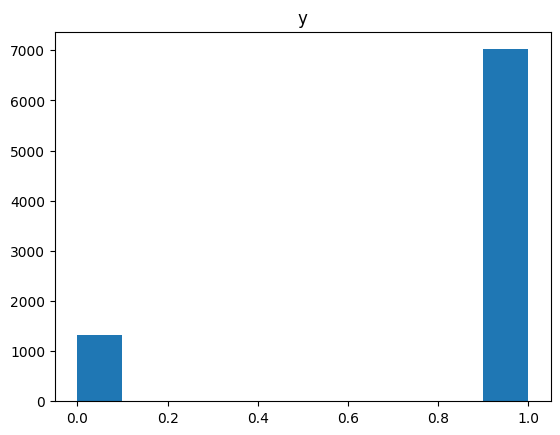

In [13]:
plt.title('y')
plt.hist(y)
plt.show()

Data is unbalanced, so accuracy is not the best metrics. <br>
I will compare metrics like roc_auc, f1, precision and recall.

In [20]:
#svc

svc = SVC(kernel='linear')
svc.fit(X_train_scaled, y_train)
y_svc = svc.predict(X_test_scaled)
print('ROC AUC score: ', roc_auc_score(y_svc,y_test))
print('F1 score: ', f1_score(y_svc,y_test))
print('Precision score: ', precision_score(y_svc,y_test))
print('Recall score: ', recall_score(y_svc,y_test))

#searching for best hyperparameters

params = {
    'C': range(1,10)
}
print('\nMetrics after searching for hyperparameters: ')
rs = RandomizedSearchCV(svc, params, n_iter=9, cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=5))
rs.fit(X_train_scaled, y_train)
y_pred = rs.predict(X_test_scaled)
print('ROC AUC score: ', roc_auc_score(y_pred,y_test))
print('F1 score: ', f1_score(y_pred,y_test))
print('Precision score: ', precision_score(y_pred,y_test))
print('Recall score: ', recall_score(y_pred,y_test))

print('\n%change due to hyperparameters optimalization:')
print('ROC AUC score % change: ', 1 - (roc_auc_score(y_pred,y_test)/roc_auc_score(y_svc,y_test)), '%')
print('F1 score % change: ', 1 - (f1_score(y_pred,y_test)/f1_score(y_svc,y_test)), '%')
print('Precision score % change: ', 1 - (precision_score(y_pred,y_test)/precision_score(y_svc,y_test)), '%')
print('Recall score % change: ', 1 - (recall_score(y_pred,y_test)/recall_score(y_svc,y_test)), '%')



ROC AUC score:  0.8446873590437528
F1 score:  0.947877114256127
Precision score:  0.9675828047921071
Recall score:  0.928958051420839

Metrics after searching for hyperparameters: 
ROC AUC score:  0.8446873590437528
F1 score:  0.947877114256127
Precision score:  0.9675828047921071
Recall score:  0.928958051420839

%change due to hyperparameters optimalization:
ROC AUC score % change:  0.0 %
F1 score % change:  0.0 %
Precision score % change:  0.0 %
Recall score % change:  0.0 %


In [19]:
#Logistic Regression

lr = LogisticRegression(random_state=random_state, max_iter=1000)
lr.fit(X_train_scaled, y_train)
y_lr = lr.predict(X_test_scaled)
print('ROC AUC score: ', roc_auc_score(y_lr,y_test))
print('F1 score: ', f1_score(y_lr,y_test))
print('Precision score: ', precision_score(y_lr,y_test))
print('Recall score: ', recall_score(y_lr,y_test))

#searching for best hyperparameters



params = {
    'C': range(1,10),
}
print('\nMetrics after searching for hyperparameters: ')
rs = RandomizedSearchCV(lr, params, n_iter=9, cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=5))
rs.fit(X_train_scaled, y_train)
y_pred = rs.predict(X_test_scaled)
print('ROC AUC score: ', roc_auc_score(y_pred,y_test))
print('F1 score: ', f1_score(y_pred,y_test))
print('Precision score: ', precision_score(y_pred,y_test))
print('Recall score: ', recall_score(y_pred,y_test))

print('\n%change due to hyperparameters optimalization:')
print('ROC AUC score % change: ', 1 - (roc_auc_score(y_pred,y_test)/roc_auc_score(y_lr,y_test)), '%')
print('F1 score % change: ', 1 - (f1_score(y_pred,y_test)/f1_score(y_lr,y_test)), '%')
print('Precision score % change: ', 1 - (precision_score(y_pred,y_test)/precision_score(y_lr,y_test)), '%')
print('Recall score % change: ', 1 - (recall_score(y_pred,y_test)/recall_score(y_lr,y_test)), '%')


ROC AUC score:  0.8349659863945579
F1 score:  0.9463482173762549
Precision score:  0.9633544749823819
Recall score:  0.9299319727891157

Metrics after searching for hyperparameters: 
ROC AUC score:  0.8349659863945579
F1 score:  0.9463482173762549
Precision score:  0.9633544749823819
Recall score:  0.9299319727891157

%change due to hyperparameters optimalization:
ROC AUC score % change:  0.0
F1 score % change:  0.0
Precision score % change:  0.0
Recall score % change:  0.0


In [26]:
#GaussianNaiveBayes

gnb = GaussianNB()
gnb.fit(X_train_scaled, y_train)
y_gnb = gnb.predict(X_test_scaled)
print('ROC AUC score: ', roc_auc_score(y_gnb,y_test))
print('F1 score: ', f1_score(y_gnb,y_test))
print('Precision score: ', precision_score(y_gnb,y_test))
print('Recall score: ', recall_score(y_gnb,y_test))

#searching for best hyperparameters

params = {
    'var_smoothing': [1e-7, 1e-11, 1e-11],
}
print('\nMetrics after searching for hyperparameters: ')
rs = RandomizedSearchCV(gnb, params, n_iter=3, cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=5))
rs.fit(X_train_scaled, y_train)
y_pred = rs.predict(X_test_scaled)
print('ROC AUC score: ', roc_auc_score(y_pred,y_test))
print('F1 score: ', f1_score(y_pred,y_test))
print('Precision score: ', precision_score(y_pred,y_test))
print('Recall score: ', recall_score(y_pred,y_test))

print('\n%change due to hyperparameters optimalization:')
print('ROC AUC score % change: ', 1 - (roc_auc_score(y_pred,y_test)/roc_auc_score(y_gnb,y_test)), '%')
print('F1 score % change: ', 1 - (f1_score(y_pred,y_test)/f1_score(y_gnb,y_test)), '%')
print('Precision score % change: ', 1 - (precision_score(y_pred,y_test)/precision_score(y_gnb,y_test)), '%')
print('Recall score % change: ', 1 - (recall_score(y_pred,y_test)/recall_score(y_gnb,y_test)), '%')

ROC AUC score:  0.7895487093352194
F1 score:  0.9368160960112955
Precision score:  0.9351656095842142
Recall score:  0.9384724186704385

Metrics after searching for hyperparameters: 
ROC AUC score:  0.7895487093352194
F1 score:  0.9368160960112955
Precision score:  0.9351656095842142
Recall score:  0.9384724186704385

%change due to hyperparameters optimalization:
ROC AUC score % change:  0.0 %
F1 score % change:  0.0 %
Precision score % change:  0.0 %
Recall score % change:  0.0 %


In [52]:
#KNeighbors

knc = KNeighborsClassifier()
knc.fit(X_train_scaled, y_train)
y_pred = knc.predict(X_test_scaled)
print(accuracy_score(y_pred, y_test))

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40 ,50],
}

gs = GridSearchCV(knc, param_grid)
gs.fit(X_train_scaled, y_train)
y_pred = gs.predict(X_test_scaled)
print(accuracy_score(y_pred, y_test))

0.8994011976047904
0.9029940119760479


In [54]:
gs.best_params_

{'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 7}

In [57]:
#Radius Neighbors

rnc = RadiusNeighborsClassifier(radius=50) #set minimum int radius to find neighbors
rnc.fit(X_train_scaled, y_train)
y_pred = rnc.predict(X_test_scaled)
print(accuracy_score(y_pred, y_test))

param_grid = {
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40, 50, 60],
    'outlier_label': ['most_frequent', None]
}

gs = GridSearchCV(rnc, param_grid)
gs.fit(X_train_scaled, y_train)
y_pred = gs.predict(X_test_scaled)
print(accuracy_score(y_pred, y_test))

0.8497005988023952
0.8497005988023952


In [58]:
#Decision Tree

dtc = DecisionTreeClassifier(random_state=random_state)
dtc.fit(X_train_scaled, y_train)
y_pred = dtc.predict(X_test_scaled)
print(accuracy_score(y_pred, y_test))

param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['sqrt', 'log2'],
    'max_leaf_nodes': [10, 20, 50]
}

gs = GridSearchCV(dtc, param_grid)
gs.fit(X_train_scaled, y_train)
y_pred = gs.predict(X_test_scaled)
print(accuracy_score(y_pred, y_test))
print(gs.best_params_)

0.9317365269461078
0.9317365269461078
{'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': 50, 'min_samples_leaf': 1, 'min_samples_split': 5}


In [61]:
#Random Forest

rfc = RandomForestClassifier(random_state=random_state)
rfc.fit(X_train_scaled, y_train)
y_pred = rfc.predict(X_test_scaled)
print(accuracy_score(y_pred, y_test))



0.9694610778443113
0.9491017964071856
{'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': 50, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


In [102]:
model = Sequential()
model.add(Dense(500, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])


In [103]:
# build the model
model.fit(X_train_scaled, y_train, epochs=20)

Epoch 1/20
209/209 [==============================] - 2s 3ms/step - loss: 0.0000e+00 - accuracy: 0.8387
Epoch 2/20
209/209 [==============================] - 1s 3ms/step - loss: 0.0000e+00 - accuracy: 0.8387
Epoch 3/20
209/209 [==============================] - 1s 3ms/step - loss: 0.0000e+00 - accuracy: 0.8387
Epoch 4/20
209/209 [==============================] - 1s 2ms/step - loss: 0.0000e+00 - accuracy: 0.8387
Epoch 5/20
209/209 [==============================] - 1s 3ms/step - loss: 0.0000e+00 - accuracy: 0.8387
Epoch 6/20
209/209 [==============================] - 1s 3ms/step - loss: 0.0000e+00 - accuracy: 0.8387
Epoch 7/20
209/209 [==============================] - 1s 3ms/step - loss: 0.0000e+00 - accuracy: 0.8387
Epoch 8/20
209/209 [==============================] - 1s 2ms/step - loss: 0.0000e+00 - accuracy: 0.8387
Epoch 9/20
209/209 [==============================] - 1s 3ms/step - loss: 0.0000e+00 - accuracy: 0.8387
Epoch 10/20
209/209 [==============================] - 1s 3ms/st

In [104]:
print('Accuracy on train dataset: ', model.evaluate(X_train_scaled, y_train, verbose=False))
print('Accuracy on test dataset: ', model.evaluate(X_test_scaled, y_test, verbose=False))
print('Sklearn accuracy metrics for test set: ', accuracy_score(model.predict(X_test_scaled), y_test))

Accuracy on train dataset:  [0.0, 0.8387241959571838]
Accuracy on test dataset:  [0.0, 0.8497005701065063]
53/53 [==============================] - 0s 2ms/step
Sklearn accuracy metrics for test set:  0.8497005988023952
